# Real World Data ConvLSTM

In [119]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import sys
import tensorflow as tf
from tensorflow import keras
import os
from pyseaflux import fCO2_to_pCO2

sys.path.insert(0, '../../src')

from utils import df_to_xarray,read_xarray, custom_rmse

sys.path.insert(0, '../../src/preprocess')
from data_preprocess import preprocess_image_reduced,preprocess_images_nfp, inverse_scale_frame
from data_preprocess import preprocess_images, inverse_scale_image, preprocess_image_reduced

In [120]:
dist_map = pd.read_csv("../../src/dist_map.csv",header=None).to_numpy()
dist_map = np.roll(np.fliplr(dist_map),180)
dist_map = np.repeat(dist_map[np.newaxis, :, : ], 480, axis=0)


def pco2_socat_preprocess(arr):
    nans=np.isnan(arr)
    arr[nans] = 0 
    arr[arr>1000]=0
    return arr

def xco2_preprocess(data):
    output = []
    min_xco2 = np.min(data)
    max_xco2=np.max(data)
    new_min=0
    new_max=255
    
    for d in data:
        num = (d-min_xco2)*(new_max-new_min)/(max_xco2-min_xco2)+new_min
        output.append(num)
    return output

In [175]:
dir_name = "../../data/real_world/MERGED-DATA_1x1_mon_198201-202112.nc"
data = xr.open_dataset(f'{dir_name}')

pco2_converted = fCO2_to_pCO2(data.fco2_ave_unwtd.data,data.sst.data)

## Data Preprocessing

- min - max scaling ?

In [174]:
chl_images = preprocess_image_reduced(data.chl.data)
sss_images = preprocess_image_reduced(data.sss.data)
sst_images = preprocess_image_reduced(data.sst.data)
dist_map = preprocess_image_reduced(dist_map)
xco2_images = xco2_preprocess(data.atm_pco2_uatm.data)

X= np.dstack((chl_images, dist_map, sss_images, sst_images, xco2_images))
X_all = X.reshape((480,180,360,5),order='F')

y_all = pco2_socat_preprocess(pco2_converted)

INPUT_SHAPE=X_all[0].shape
OUTPUT_SHAPE=y_all[0].shape

INPUT_SHAPE, X_all.shape, y_all.shape

((180, 360, 5), (480, 180, 360, 5), (480, 180, 360))

## Transfer Learning 1
- With 1998 date

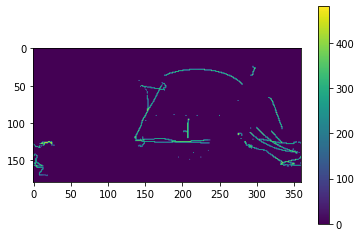

In [144]:
img=plt.imshow(y_all[400])
plt.colorbar(img)

In [124]:
model_path="../../models/base_model/u_net_dist.h5"

cnn_model = tf.keras.models.load_model(model_path, custom_objects={'custom_rmse':custom_rmse})
predicted_image= cnn_model.predict(X_all,verbose=1)
coord=np.isnan(np.repeat(np.expand_dims(data.mask.data,axis=0),480,axis=0))
predicted_image[coord] = 0

15/15 [==============================] - 1s 73ms/step


In [125]:
# without transfer learning rmse
print(custom_rmse(y_all,predicted_image))

tf.Tensor(300.31158, shape=(), dtype=float32)


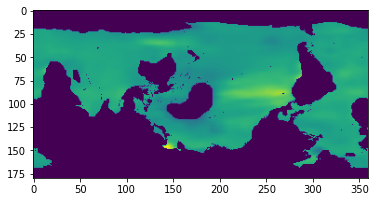

In [126]:
#without any training
plt.imshow(predicted_image[400])

In [176]:
# transfer learning
for layer in cnn_model.layers[:-4]:
    layer.trainable = False

In [187]:
from tensorflow.keras import backend as K
tf.keras.backend.clear_session()

# best : lr = 0.05 , batch_size = 64

#optimizer = keras.optimizers.Adam(learning_rate=0.05)
optimizer = keras.optimizers.Adam(learning_rate=0.002)



cnn_model.compile(loss=custom_rmse, optimizer=optimizer)

model_path="../../models/transfer_CNN_real.h5"

early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

history = cnn_model.fit(X_all,y_all, epochs=100, 
                         validation_data=(X_all,y_all),
                         workers=-1,batch_size=32,
                         callbacks=callbacks)

Epoch 1/100
15/15 [==============================] - 5s 280ms/step - loss: 45.7839 - val_loss: 35.5809
Epoch 2/100
15/15 [==============================] - 3s 208ms/step - loss: 47.8930 - val_loss: 35.5615
Epoch 3/100
15/15 [==============================] - 3s 209ms/step - loss: 52.2883 - val_loss: 35.8280
Epoch 4/100
15/15 [==============================] - 3s 208ms/step - loss: 54.9410 - val_loss: 35.6327
Epoch 5/100
15/15 [==============================] - 3s 209ms/step - loss: 50.8735 - val_loss: 35.6181
Epoch 6/100
15/15 [==============================] - 3s 207ms/step - loss: 53.0738 - val_loss: 35.7343
Epoch 7/100
15/15 [==============================] - 3s 208ms/step - loss: 52.0786 - val_loss: 35.8265
Epoch 8/100
15/15 [==============================] - 3s 209ms/step - loss: 50.5559 - val_loss: 35.5132
Epoch 9/100
15/15 [==============================] - 3s 207ms/step - loss: 48.0955 - val_loss: 36.0224
Epoch 10/100
15/15 [==============================] - 3s 208ms/step - los

In [ ]:
cnn_model = tf.keras.models.load_model('../../models/transfer_CNN_real.h5', custom_objects={'custom_rmse':custom_rmse})

predicted_image = cnn_model.predict(X_all,verbose=1)
coord=np.isnan(np.repeat(np.expand_dims(data.mask.data,axis=0),480,axis=0))
predicted_image[coord] = 0

 7/15 [=============>................] - ETA: 0s

In [ ]:
import matplotlib.colors as mcolors
norm = mcolors.Normalize(vmin=0, vmax = 700)
img=plt.imshow(np.flipud(predicted_image[280]),cmap="coolwarm", interpolation="nearest", norm=norm)
plt.colorbar(img)

In [ ]:
img=plt.imshow(np.flipud(y_all[280]),cmap="coolwarm", interpolation="nearest", norm=norm)
plt.colorbar(img)

In [ ]:
custom_rmse(y_all,predicted_image)

## Transfer learning 2
- after 1998 date

In [62]:
chl_images = preprocess_image_reduced(data.chl.data)
sss_images = preprocess_image_reduced(data.sss.data)
sst_images = preprocess_image_reduced(data.sst.data)
dist_map = preprocess_image_reduced(dist_map)
X = np.dstack((chl_images, dist_map, sss_images, sst_images, xco2_images))
X = X.reshape((480,180,360,5),order='F')
y = pco2_socat_preprocess(data.fco2_ave_unwtd.data)

X_all = X[192:]
y_all = y[192:]

INPUT_SHAPE=X_all[0].shape
OUTPUT_SHAPE=y_all[0].shape

INPUT_SHAPE, X_all.shape, y_all.shape

((180, 360, 5), (288, 180, 360, 5), (288, 180, 360))

In [63]:
model_path="../../models/base_model/u_net_dist.h5"

cnn_model = tf.keras.models.load_model(model_path, custom_objects={'custom_rmse':custom_rmse})


In [65]:
for layer in cnn_model.layers[:-4]:
    layer.trainable = False

tf.keras.backend.clear_session()

optimizer = keras.optimizers.Adam(learning_rate=0.01)


cnn_model.compile(loss=custom_rmse, optimizer=optimizer)

model_path="../../models/transfer_CNN_real2.h5"

early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

history = cnn_model.fit(X_all,y_all, epochs=50, 
                         validation_data=(X_all,y_all),
                         workers=-1,batch_size=32,
                         callbacks=callbacks)

Epoch 1/50
9/9 [==============================] - 3s 275ms/step - loss: 153.9352 - val_loss: 119.4640
Epoch 2/50
9/9 [==============================] - 2s 258ms/step - loss: 129.4935 - val_loss: 128.1852
Epoch 3/50
9/9 [==============================] - 2s 258ms/step - loss: 122.4043 - val_loss: 102.8802
Epoch 4/50
9/9 [==============================] - 2s 258ms/step - loss: 105.0523 - val_loss: 96.0997
Epoch 5/50
9/9 [==============================] - 2s 258ms/step - loss: 103.9604 - val_loss: 87.2156
Epoch 6/50
9/9 [==============================] - 2s 257ms/step - loss: 94.5996 - val_loss: 88.5298
Epoch 7/50
9/9 [==============================] - 2s 258ms/step - loss: 92.3820 - val_loss: 85.3086
Epoch 8/50
9/9 [==============================] - 2s 257ms/step - loss: 90.7703 - val_loss: 79.2675
Epoch 9/50
9/9 [==============================] - 2s 259ms/step - loss: 84.2269 - val_loss: 73.1920
Epoch 10/50
9/9 [==============================] - 2s 256ms/step - loss: 73.7306 - val_loss:

In [67]:
cnn_model = tf.keras.models.load_model('../../models/transfer_CNN_real2.h5', custom_objects={'custom_rmse':custom_rmse})

predicted_image = cnn_model.predict(X_all,verbose=1)
coord=np.isnan(np.repeat(np.expand_dims(data.mask.data,axis=0),288,axis=0))
predicted_image[coord] = 0

full_truth = data.fco2_ave_unwtd.data[192:]
full_truth[coord] = 0

9/9 [==============================] - 1s 77ms/step


In [68]:
custom_rmse(full_truth,predicted_image)

<tf.Tensor: shape=(), dtype=float32, numpy=38.310745>

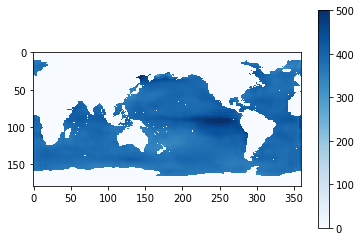

In [69]:
import matplotlib.colors as mcolors
norm = mcolors.Normalize(vmin=0, vmax = 500)

img=plt.imshow(np.flipud(predicted_image[280]),cmap="Blues", interpolation="nearest", norm=norm)
plt.colorbar(img)

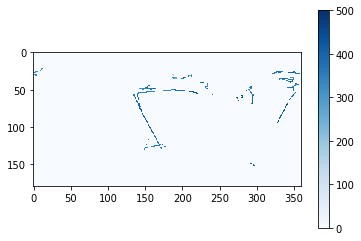

In [70]:
img=plt.imshow(np.flipud(full_truth[280]),cmap="Blues", interpolation="nearest", norm=norm)
plt.colorbar(img)

## ConvLSTM transfer learning

In [155]:
X_index=np.lib.stride_tricks.sliding_window_view(range(480),3)
X = np.dstack((chl_images, dist_map, sss_images, sst_images, xco2_images,predicted_image))
X = X.reshape((480,180,360,6),order='F')
X = X[X_index][:-1]

y_tf=np.expand_dims(y_all[X_index][1:],axis=4)

X.shape, y_tf.shape # changed sliding

((477, 3, 180, 360, 6), (477, 3, 180, 360, 1))

In [156]:
tf.keras.backend.clear_session()

convlstm_model_path = "../../models/ConvLSTM_with_pco2_2.h5"
convlstm_model = tf.keras.models.load_model(convlstm_model_path, custom_objects={'custom_rmse':custom_rmse})



In [161]:

tmp = np.nan_to_num(data.fco2_ave_unwtd.data[X_index][1:])
y_true_full = np.expand_dims(tmp,axis=4)
print(y_true_full.shape)

coord = (y_true_full==0.0)

predicted_frames= convlstm_model.predict(X,verbose=1)
predicted_frames[coord] = 0

print("ConvLSTM Full RMSE score w/o finetuning:")
a=custom_rmse(y_true_full[:,1:2],predicted_frames[:,1:2])
print(a)

(477, 3, 180, 360, 1)
15/15 [==============================] - 17s 1s/step
ConvLSTM Full RMSE score w/o finetuning:
tf.Tensor(118.25299, shape=(), dtype=float32)


In [162]:
for layer in convlstm_model.layers[:-2]:
    layer.trainable = False

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 3, 180, 360, 32)   121728    
_________________________________________________________________
batch_normalization (BatchNo (None, 3, 180, 360, 32)   128       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 3, 180, 360, 32)   204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 3, 180, 360, 32)   128       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 3, 180, 360, 32)   73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 3, 180, 360, 32)   128       
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, 3, 180, 360, 32)   8

In [164]:
convlstm_model.compile(
    loss=custom_rmse, optimizer=keras.optimizers.Adam(learning_rate=3e-3),
)

model_path="../../models/transfer_ConvLSTM_real.h5"

early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

epochs = 50
batch_size = 16

In [165]:
history = convlstm_model.fit(
    X,
    y_tf,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X, y_tf),
    callbacks=callbacks,
)

Epoch 1/50
30/30 [==============================] - 50s 2s/step - loss: 89.1503 - val_loss: 52.3580
Epoch 2/50
30/30 [==============================] - 42s 1s/step - loss: 51.8558 - val_loss: 42.2300
Epoch 3/50
30/30 [==============================] - 42s 1s/step - loss: 46.3071 - val_loss: 40.8581
Epoch 4/50
30/30 [==============================] - 42s 1s/step - loss: 42.9207 - val_loss: 40.8685
Epoch 5/50
30/30 [==============================] - 42s 1s/step - loss: 41.4903 - val_loss: 40.1000
Epoch 6/50
30/30 [==============================] - 42s 1s/step - loss: 41.2448 - val_loss: 39.2866
Epoch 7/50
30/30 [==============================] - 42s 1s/step - loss: 41.0809 - val_loss: 39.1262
Epoch 8/50
30/30 [==============================] - 42s 1s/step - loss: 40.7227 - val_loss: 37.7070
Epoch 9/50
30/30 [==============================] - 42s 1s/step - loss: 39.5138 - val_loss: 37.8623
Epoch 10/50
30/30 [==============================] - 42s 1s/step - loss: 39.4300 - val_loss: 38.6395

KeyboardInterrupt: 

In [166]:
coord=np.isnan(np.repeat(np.expand_dims(data.mask.data,axis=0),480,axis=0)[X_index][1:])
coord.shape

(477, 3, 180, 360)

In [167]:
tf_model = tf.keras.models.load_model("../../models/transfer_ConvLSTM_real.h5", custom_objects={'custom_rmse':custom_rmse})


predicted_frames= tf_model.predict(X,verbose=1)
predicted_frames[coord] = 0




15/15 [==============================] - 17s 1s/step


In [168]:
print("Full RMSE score:")
a=custom_rmse(y_true_full[:,1:2],predicted_frames[:,1:2])
print(a)

Full RMSE score:
tf.Tensor(152.71199, shape=(), dtype=float32)


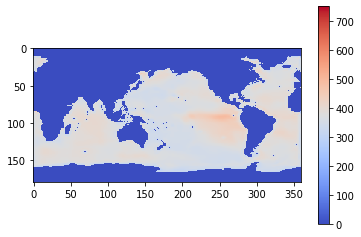

In [169]:
import matplotlib.colors as mcolors
norm = mcolors.Normalize(vmin=0, vmax = 750)

img=plt.imshow(np.flipud(predicted_frames[420,1:2][0]),cmap="coolwarm", interpolation="nearest", norm=norm)
plt.colorbar(img)

# Gif Generation

In [173]:
# gif generation for cnn

import matplotlib.colors as mcolors
import imageio


norm = mcolors.Normalize(vmin=0, vmax = 750)
norm2 = mcolors.TwoSlopeNorm(vmin=-500, vmax = 500, vcenter=0)


filenames = []

for i in range(421):
    figure, axis = plt.subplots(1, 3,figsize=(18, 10))
    
    img=axis[0].imshow(np.flipud(predicted_image[i]),cmap="coolwarm", interpolation="nearest", norm=norm)
    axis[0].set_title("prediction")
    plt.colorbar(img,ax=axis)

    img1=axis[1].imshow(np.flipud(y_all[i]),cmap="coolwarm", interpolation="nearest",norm=norm)
    axis[1].set_title("true")

    img2=axis[2].imshow(np.flipud(y_all[i]-(predicted_image[i])),cmap="RdBu", norm=norm2)
    axis[2].set_title("residual")
    plt.colorbar(img2,ax=axis)
    
    text = "rmse: "+str(np.round(custom_rmse(y_all[i],predicted_image[i]),2))
    plt.text(-60, -60, text, fontsize = 20)
    
    filename = f'{i}.png'
    filenames.append(filename)
    
    # save frame
    plt.savefig(filename)
    plt.close()


with imageio.get_writer('../../assets/cnn_real_transfer.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)